In [2]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Cargar el dataset principal de solicitudes de adelanto en efectivo
cr = pd.read_csv('../project_dataset/extract - cash request - data analyst.csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [7]:
# Crear una copia del DataFrame para preservar el original
credit_requests = cr.copy()

In [8]:
# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fs = pd.read_csv('../project_dataset/extract - fees - data analyst - .csv')
fs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [20]:
# Crear una copia del DataFrame para preservar el original
fees = fs.copy()

rows_with_null_id = fees[fees['cash_request_id'].isnull()]
print(rows_with_null_id)

         id  cash_request_id             type     status category  \
1911   2990              NaN  instant_payment  cancelled      NaN   
1960   3124              NaN  instant_payment  cancelled      NaN   
4605   5185              NaN  instant_payment  cancelled      NaN   
11870  3590              NaN  instant_payment  cancelled      NaN   

       total_amount                              reason  \
1911            5.0  Instant Payment Cash Request 11164   
1960            5.0  Instant Payment Cash Request 11444   
4605            5.0  Instant Payment Cash Request 11788   
11870           5.0  Instant Payment Cash Request 12212   

                          created_at                     updated_at paid_at  \
1911   2020-08-06 22:42:34.525373+00  2020-11-04 16:01:17.296048+00     NaN   
1960   2020-08-08 06:33:06.244651+00  2020-11-04 16:01:08.332978+00     NaN   
4605   2020-08-26 09:39:37.362933+00  2020-11-04 16:01:36.492576+00     NaN   
11870  2020-08-12 14:20:06.657075+00  2020

In [18]:
# Clean `credit_requests`
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cash_request = credit_requests
cash_request.fillna({"user_id": cash_request["deleted_account_id"]}, inplace=True)

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')
    cash_request[col] = cash_request[col].dt.tz_localize(None)
    credit_requests[col] = pd.to_datetime(cash_request[col], errors='coerce')
    credit_requests[col] = credit_requests[col].dt.tz_localize(None)

# 5. **Limpieza de datos** Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
#cash_request.drop(columns=["deleted_account_id"], inplace=True)
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  datetime64[ns]
 5   user_id                     23970 non-null  float64       
 6   moderated_at                15912 non-null  datetime64[ns]
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          3050 non-null   datetime64[ns]
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             12040 non-null  datetime64[ns]
 11  transfer_type               23970 non-null  object    

In [22]:
# 1. Manejo de valores faltantes
# - Impute 'category' with 'Unknown', keep `paid_at`, `from_date`, `to_date` for further filtering

data_cleaned['category'] = data_cleaned['category'].fillna('Unknown')

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')
    data_cleaned[col] = data_cleaned[col].dt.tz_localize(None)
    
# Standardize column names
data_cleaned.columns = data_cleaned.columns.str.lower().str.replace(' ', '_')

# Resultado final
display(data_cleaned.info())
data_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 21057 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               21057 non-null  int64         
 1   cash_request_id  21057 non-null  float64       
 2   type             21057 non-null  object        
 3   status           21057 non-null  object        
 4   category         21057 non-null  object        
 5   total_amount     21057 non-null  float64       
 6   reason           21057 non-null  object        
 7   created_at       21057 non-null  datetime64[ns]
 8   updated_at       21057 non-null  datetime64[ns]
 9   paid_at          15438 non-null  datetime64[ns]
 10  from_date        6749 non-null   datetime64[ns]
 11  to_date          6512 non-null   datetime64[ns]
 12  charge_moment    21057 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(1), object(5)
memory usage: 2.2+ MB


None

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,Unknown,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150,2020-10-13 14:25:09.396112,2020-12-17 14:50:07.470110,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653,2020-10-13 14:25:15.537063,2020-12-08 17:13:10.459080,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972,2020-10-23 10:10:58.352994,2020-11-04 19:34:37.432910,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958,2020-10-31 15:46:53.643982,2020-11-19 05:09:22.500223,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432,2020-10-13 14:25:03.267983,2020-11-02 14:45:20.355598,NaT,NaT,after


In [12]:
# Merge on `id` and `cash_request_id`
merged_data = pd.merge(
    cash_request,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='inner'
)

print(merged_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        21057 non-null  int64         
 1   amount                      21057 non-null  float64       
 2   status_x                    21057 non-null  object        
 3   created_at_x                21057 non-null  datetime64[ns]
 4   updated_at_x                21057 non-null  datetime64[ns]
 5   user_id                     21057 non-null  float64       
 6   moderated_at                11115 non-null  datetime64[ns]
 7   deleted_account_id          906 non-null    float64       
 8   reimbursement_date          2291 non-null   datetime64[ns]
 9   cash_request_received_date  19763 non-null  object        
 10  money_back_date             14758 non-null  datetime64[ns]
 11  transfer_type               21057 non-null  object    

In [9]:
# Average requested amount and fee
print(merged_data['amount'].mean())
print(merged_data['total_amount'].mean())

# Correlation between credit amount and fees
print(merged_data[['amount', 'total_amount']].corr())


81.83354703898941
5.0002374507289735
                amount  total_amount
amount        1.000000     -0.008142
total_amount -0.008142      1.000000


In [19]:
# Total fees by type
fees_by_type = merged_data.groupby('type')['total_amount'].sum()
print(fees_by_type)
fees_by_type = merged_data.groupby('type')['total_amount'].mean()
print(fees_by_type)

# Average fee-to-credit ratio
merged_data['fee_to_credit_ratio'] = merged_data['total_amount'] / merged_data['amount']
avg_ratio = merged_data['fee_to_credit_ratio'].mean()
print(f"Average Fee-to-Credit Ratio: {avg_ratio:.2%}")


type
incident           10980.0
instant_payment    55480.0
postpone           38830.0
Name: total_amount, dtype: float64
type
incident           5.000000
instant_payment    5.000451
postpone           5.000000
Name: total_amount, dtype: float64
Average Fee-to-Credit Ratio: 7.61%


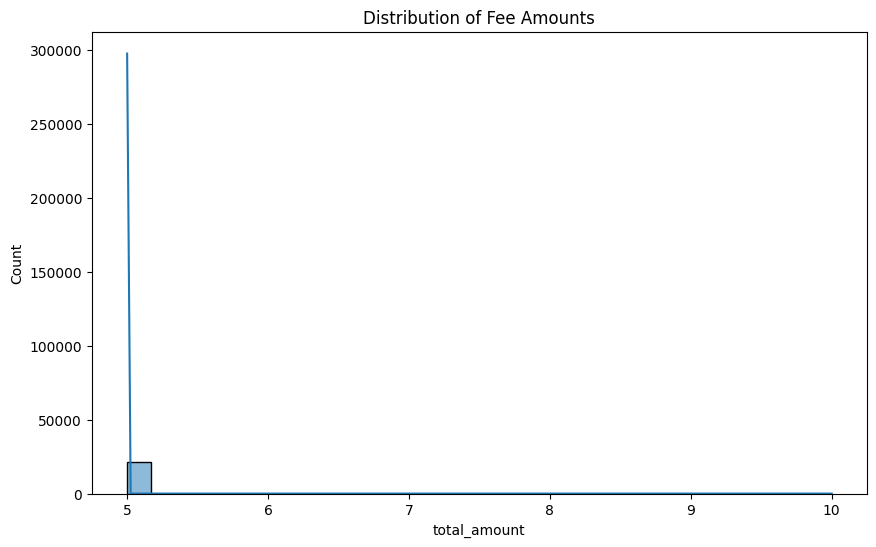

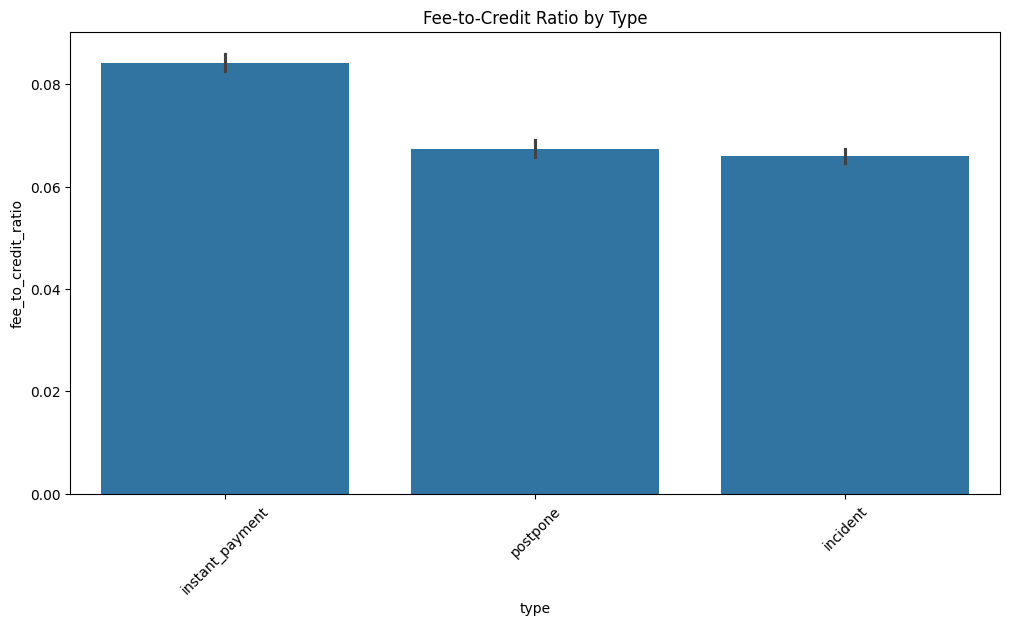

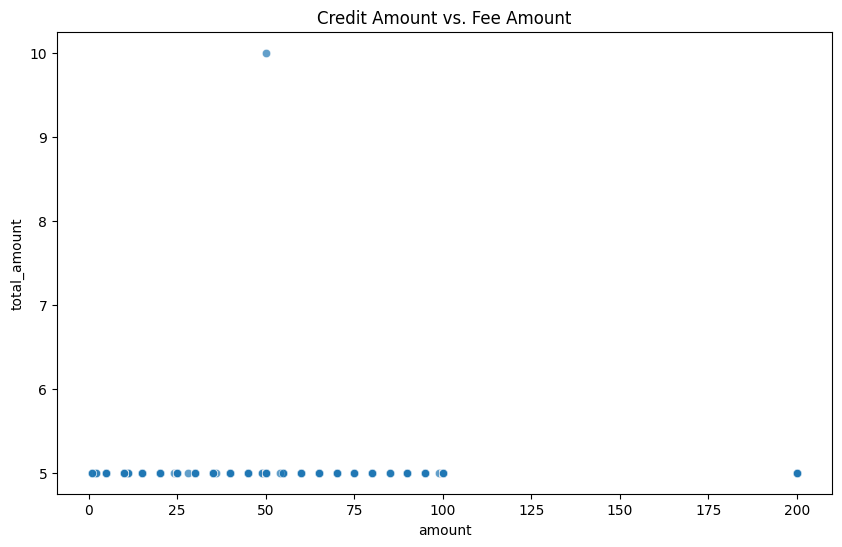

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Fee Amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['total_amount'], bins=30, kde=True)
plt.title('Distribution of Fee Amounts')
plt.show()

# Fee-to-Credit Ratio by Type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='fee_to_credit_ratio', data=merged_data)
plt.title('Fee-to-Credit Ratio by Type')
plt.xticks(rotation=45)
plt.show()

# Credit Amount vs. Fee Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount', y='total_amount', data=merged_data, alpha=0.7)
plt.title('Credit Amount vs. Fee Amount')
plt.show()


In [12]:
# verify all credit requests have fees

# Perform a left join to ensure all credit requests are included
merged_data2 = pd.merge(
    credit_requests,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='left'
)
merged_data2.info()
# Check for credit requests without fees
no_fees = merged_data2[merged_data2['total_amount'].isna()]

# Display the result
if no_fees.empty:
    print("All credit requests have fees associated with them.")
else:
    print(f"There are {len(no_fees)} credit requests without fees.")
    print(no_fees[['id_x', 'amount', 'status_x']])  # Display relevant columns for inspection

# Check statuses of credit requests without fees
print(no_fees['status_x'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status_x                    32094 non-null  object        
 3   created_at_x                32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  float64       
 6   moderated_at                21530 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          4061 non-null   datetime64[ns]
 9   cash_request_received_date  24149 non-null  object        
 10  money_back_date             17204 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

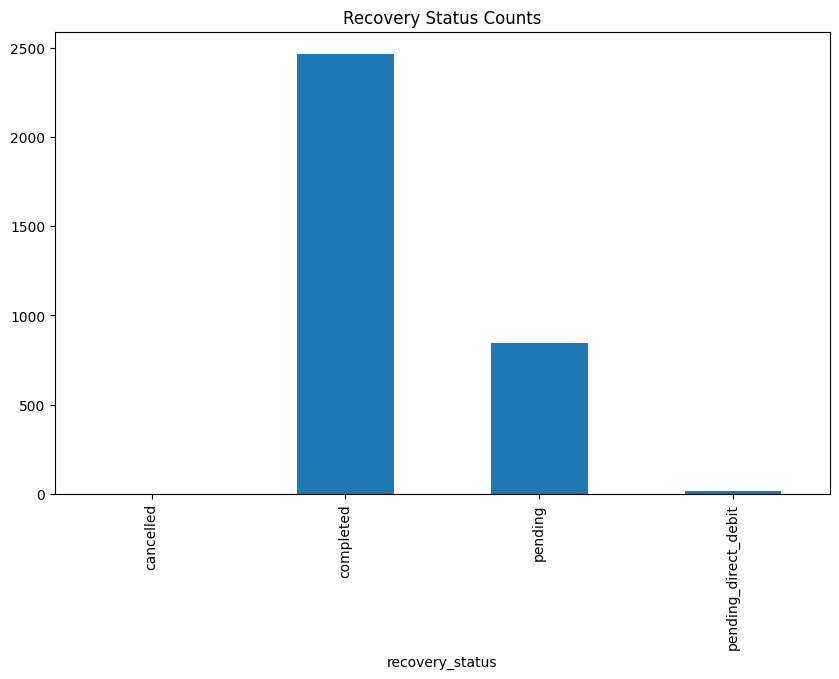

In [13]:
recovery_rates = credit_requests.groupby('recovery_status').size()
recovery_rates.plot(kind='bar', figsize=(10, 6), title='Recovery Status Counts')
plt.show()


In [14]:
missing_by_status = credit_requests.groupby('status').apply(lambda x: x.isnull().sum())
print(missing_by_status)


                       id  amount  status  created_at  updated_at  user_id  \
status                                                                       
active                  0       0       0           0           0        0   
canceled                0       0       0           0           0        0   
direct_debit_rejected   0       0       0           0           0        0   
direct_debit_sent       0       0       0           0           0        0   
money_back              0       0       0           0           0        0   
rejected                0       0       0           0           0        0   
transaction_declined    0       0       0           0           0        0   

                       moderated_at  deleted_account_id  reimbursement_date  \
status                                                                        
active                           37                  59                  58   
canceled                         33                   7     

In [15]:
merged_data.info()

merged_data.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        21057 non-null  int64         
 1   amount                      21057 non-null  float64       
 2   status_x                    21057 non-null  object        
 3   created_at_x                21057 non-null  datetime64[ns]
 4   updated_at_x                21057 non-null  datetime64[ns]
 5   user_id                     21057 non-null  float64       
 6   moderated_at                11115 non-null  datetime64[ns]
 7   deleted_account_id          906 non-null    float64       
 8   reimbursement_date          2291 non-null   datetime64[ns]
 9   cash_request_received_date  19763 non-null  object        
 10  money_back_date             14758 non-null  datetime64[ns]
 11  transfer_type               21057 non-null  object    

,id_x,amount,status_x,created_at_x,updated_at_x,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,category,total_amount,reason,created_at_y,updated_at_y,paid_at,from_date,to_date,charge_moment,fee_to_credit_ratio
0,23534,25.0,money_back,2020-10-23 15:20:26.163927,2020-12-18 13:08:29.099365,21465.0,NaT,NaN,NaT,NaN,...,NaN,5.0,Instant Payment Cash Request 23534,2020-10-23 15:21:35.895711+00,2020-10-23 15:21:35.89574+00,2020-11-06 07:16:22.014422+00,NaN,NaN,after,0.20
1,2203,100.0,money_back,2020-05-27 02:26:27.615190,2020-06-09 11:25:51.726360,2109.0,2020-05-27 10:02:13.094467,NaN,NaT,2020-05-29,...,NaN,5.0,Postpone Cash Request 2203,2020-06-09 11:25:52.449808+00,2020-10-13 14:25:00.867548+00,NaN,2020-06-15 02:26:27+00,2020-07-15 02:26:27+00,before,0.05
2,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:39.63422+00,2020-10-13 14:25:16.660127+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,0.05
3,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:52.603153+00,2020-10-13 14:25:16.661371+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,0.05
4,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,NaN,5.0,Postpone Cash Request 6098,2020-08-13 11:00:39.879521+00,2020-10-13 14:25:16.662449+00,NaN,2020-08-03 22:00:00+00,2020-09-01 11:00:34.027+00,after,0.05
5,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,NaN,5.0,Postpone Cash Request 6098,2020-08-19 16:30:48.607923+00,2020-10-13 14:25:16.91377+00,NaN,2020-08-03 22:00:00+00,2020-09-03 16:30:45.837+00,after,0.05
6,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,month_delay_on_payment,5.0,month delay on payment - 9/2020,2020-09-10 22:32:51.726321+00,2020-12-15 17:07:43.211171+00,NaN,NaN,NaN,after,0.05
7,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,rejected_direct_debit,5.0,rejected direct debit,2020-08-11 22:27:55.370079+00,2020-10-13 14:25:05.431752+00,NaN,NaN,NaN,after,0.05
8,6098,100.0,active,2020-07-01 09:30:03.145410,2020-08-11 22:27:58.240406,23328.0,2020-07-01 16:44:53.070844,NaN,NaT,2020-07-03,...,month_delay_on_payment,5.0,month delay on payment - 9/2020,2020-10-10 23:26:31.48232+00,2020-10-13 14:25:03.371439+00,NaN,NaN,NaN,after,0.05
9,3611,100.0,direct_debit_rejected,2020-06-17 11:03:32.617120,2020-07-21 22:09:32.695508,15415.0,2020-06-17 14:52:56.141750,NaN,2020-07-17 11:03:52.469,2020-06-18,...,rejected_direct_debit,5.0,rejected direct debit,2020-07-21 22:09:32.585036+00,2020-10-13 14:25:00.836605+00,NaN,NaN,NaN,after,0.05


In [16]:
# sequence analysis

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter for a specific customer and transaction
specific_transaction = events[(events['user_id'] == 23328) & (events['id_x'] == 6098)]

# Plot the events
plt.figure(figsize=(10, 6))
plt.plot(specific_transaction['event_date'], specific_transaction['event'], marker='o')

# Formatting the timeline
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.title(f'Sequence of Events for Transaction (User )')
plt.xlabel('Date')
plt.ylabel('Event')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'events' is not defined

In [32]:

# credit requests without fees

# Identify credit requests without a corresponding fee
credit_requests_without_fees = credit_requests[~credit_requests['id'].isin(fees['cash_request_id'])]

# Check the shape and preview
print(f"Number of credit requests without corresponding fees: {credit_requests_without_fees.shape[0]}")
credit_requests_without_fees.head()
credit_requests_without_fees.info()


Number of credit requests without corresponding fees: 11037
<class 'pandas.core.frame.DataFrame'>
Index: 11037 entries, 0 to 23955
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          11037 non-null  int64         
 1   amount                      11037 non-null  float64       
 2   status                      11037 non-null  object        
 3   created_at                  11037 non-null  datetime64[ns]
 4   updated_at                  11037 non-null  datetime64[ns]
 5   user_id                     11037 non-null  float64       
 6   moderated_at                10415 non-null  datetime64[ns]
 7   deleted_account_id          1667 non-null   float64       
 8   reimbursement_date          1770 non-null   datetime64[ns]
 9   cash_request_received_date  4386 non-null   object        
 10  money_back_date             2446 non-null   datetime64[ns]
 11 

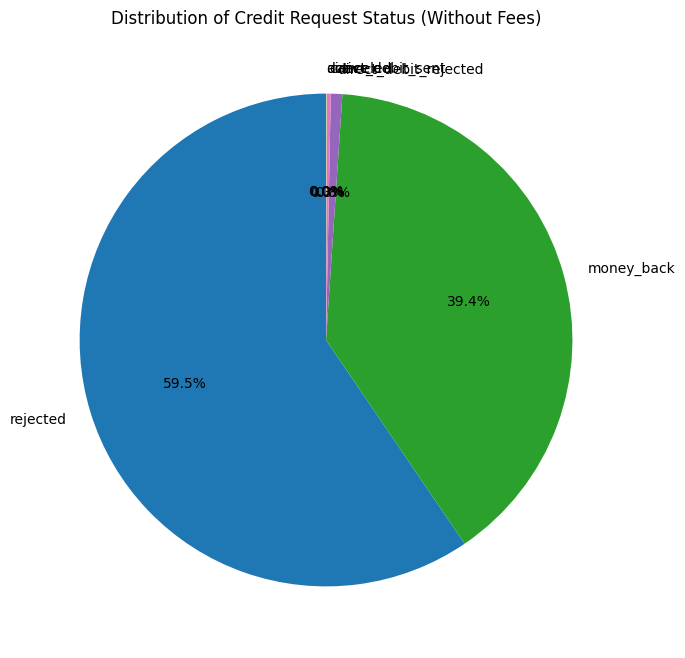

In [33]:
import matplotlib.pyplot as plt

# Count the occurrences of each 'status' value
status_counts = credit_requests_without_fees['status'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20', legend=False)

# Formatting the chart
plt.title('cash requests sin Fees correspondiente)')
plt.ylabel('')  # Remove y-axis label for cleaner look
plt.show()


In [34]:
# Count the occurrences of each 'status' value
status_counts = credit_requests_without_fees['status'].value_counts()

# Convert to a DataFrame for better readability
status_counts_table = status_counts.reset_index()
status_counts_table.columns = ['Status', 'Count']

# Display the table
print(status_counts_table)


                  Status  Count
0               rejected   6568
1             money_back   4352
2  direct_debit_rejected     83
3               canceled     29
4                 active      3
5      direct_debit_sent      2


In [35]:
# Check for duplicate IDs
duplicate_ids = credit_requests[credit_requests['id'].duplicated(keep=False)]

# Count the number of duplicate IDs
num_duplicates = duplicate_ids['id'].nunique()

# Display results
print(f"Number of duplicate IDs: {num_duplicates}")
if num_duplicates > 0:
    print("Sample duplicate entries:")
    print(duplicate_ids.sort_values(by='id').head())
else:
    print("No duplicate IDs found.")


Number of duplicate IDs: 0
No duplicate IDs found.


In [39]:
# Get distinct values in the 'reason' column
distinct_reasons = fees['reason'].unique()

# Display the distinct values
print(f"Distinct values in 'reason' column ({len(distinct_reasons)} unique values):")

i=0
for reason in distinct_reasons:
    print(f"- {reason}")
    i+=1
    if i > 20:
        break;


Distinct values in 'reason' column (15149 unique values):
- Instant Payment Cash Request 14941
- rejected direct debit
- Instant Payment Cash Request 23371
- Instant Payment Cash Request 26772
- Instant Payment Cash Request 19350
- Instant Payment Cash Request 24052
- Instant Payment Cash Request 25983
- Instant Payment Cash Request 26572
- Postpone Cash Request 22106
- Instant Payment Cash Request 24756
- Postpone Cash Request 21897
- Postpone Cash Request 25490
- Instant Payment Cash Request 26568
- Instant Payment Cash Request 25902
- Instant Payment Cash Request 26565
- Postpone Cash Request 19876
- Instant Payment Cash Request 22136
- Postpone Cash Request 24564
- Instant Payment Cash Request 25527
- Postpone Cash Request 19909
- Postpone Cash Request 22357


In [41]:
reason_counts = fees['cash_request_id'].value_counts()
#print(reason_counts)

# Filter to include only reasons with a count greater than 1
reason_counts_filtered = reason_counts[reason_counts > 1]

# Display the filtered counts
print("Distinct 'reason' counts greater than 1:")
print(reason_counts_filtered)

Distinct 'reason' counts greater than 1:
cash_request_id
12225.0    35
5006.0     28
4410.0     24
12452.0    23
11376.0    21
2358.0     19
11746.0    17
15319.0    16
4956.0     15
8713.0     15
11968.0    15
11585.0    15
11277.0    14
18264.0    14
17793.0    14
3759.0     13
11658.0    13
15105.0    13
10880.0    12
6727.0     12
2396.0     12
24025.0    12
8202.0     12
18785.0    12
6717.0     12
2211.0     12
19849.0    11
9541.0     11
6712.0     11
18194.0    11
12627.0    11
11719.0    10
12126.0    10
10436.0    10
13820.0    10
2641.0     10
6982.0     10
14282.0    10
16716.0    10
13516.0    10
16023.0    10
16319.0    10
13324.0    10
2346.0     10
6625.0     10
15312.0    10
3676.0     10
5019.0     10
4981.0     10
13072.0     9
8451.0      9
17112.0     9
18435.0     9
10378.0     9
3363.0      9
15865.0     9
16535.0     9
6174.0      9
3705.0      9
6065.0      9
9212.0      9
2710.0      9
14689.0     9
12232.0     9
14300.0     9
8749.0      9
3431.0      9
22567

In [ ]:
reason_counts = fees['reason'].value_counts()
print(reason_counts)

# Filter to include only reasons with a count greater than 1
reason_counts_filtered = reason_counts[reason_counts > 1]

# Display the filtered counts
print("Distinct 'reason' counts greater than 1:")
print(reason_counts_filtered)


In [32]:
# Create a new column with the first 20 characters of the 'reason' column
fees['reason_truncated'] = fees['reason'].str[:22]

# Count occurrences of each truncated reason
reason_counts = fees['reason_truncated'].value_counts()

# Display the counts
print("Distinct 'reason' counts (based on first 20 characters):")
print(reason_counts)


Distinct 'reason' counts (based on first 20 characters):
reason_truncated
Instant Payment Cash R    11099
Postpone Cash Request      7766
rejected direct debit      1599
month delay on payment      597
Name: count, dtype: int64


In [ ]:
fees.info()


In [29]:
# Count the occurrences of each cash_request_id
cash_request_id_counts = fees['cash_request_id'].value_counts()

# Display the counts in descending order
print("Count of rows per distinct cash_request_id (descending order):")
print(cash_request_id_counts)


Count of rows per distinct cash_request_id (descending order):
cash_request_id
12225.0    35
5006.0     28
4410.0     24
12452.0    23
11376.0    21
           ..
24822.0     1
26203.0     1
22956.0     1
23207.0     1
25331.0     1
Name: count, Length: 12933, dtype: int64


In [30]:
    # Filter rows where fees total_amount > 5
    filtered_rows = fees[fees['total_amount'] > 5]
    
    # Check if any rows are found
    if filtered_rows.empty:
        print(f"No rows found where cash_request_id is empty.")
    else:
        # Sort the filtered rows by 'updated_at' column
        filtered_rows_sorted = filtered_rows.sort_values(by='created_at')
    
        # Display the sorted rows
        print(f"Rows where total_amount > 5, ordered by updated_at:")
        print(filtered_rows_sorted[['reason', 'total_amount']])
        filtered_rows_cr = cash_request[cash_request['id'] == 22799]
        print(filtered_rows_cr[['id', 'amount']])


Rows where total_amount > 5, ordered by updated_at:
                                   reason  total_amount
20604  Instant Payment Cash Request 22799          10.0
          id  amount
23689  22799    50.0


In [31]:
print("====================================")
print(cash_request[cash_request['amount'] > 150])

         id  amount      status                 created_at  \
467    1140   200.0    rejected 2020-04-11 13:26:58.710517   
557     885   200.0    rejected 2020-03-15 13:45:07.357731   
727    1032   200.0    rejected 2020-04-03 06:14:19.552837   
763    1967   200.0  money_back 2020-05-18 07:57:49.949907   
980    1732   200.0  money_back 2020-05-13 14:13:57.448290   
1349   3575   200.0    rejected 2020-06-17 01:10:51.553474   
1510   2099   200.0  money_back 2020-05-21 12:53:43.630055   
2282   1556   200.0  money_back 2020-05-05 05:17:40.784144   
2332   2184   200.0  money_back 2020-05-26 14:35:16.092311   
3061   8659   200.0    rejected 2020-07-17 12:57:31.472230   
3221   7401   200.0    rejected 2020-07-09 21:54:35.238416   
3363   8958   200.0    rejected 2020-07-19 15:41:31.640664   
5530    737   200.0  money_back 2020-02-26 18:05:27.038373   
6083    843   200.0  money_back 2020-03-11 07:23:35.317042   
6874   1319   200.0  money_back 2020-04-22 06:46:57.197984   
6970    

In [30]:

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.max_rows', None)  # Show all rows if necessary
# Replace `value_to_filter` with the specific cash_request_id value you want to filter by
value_to_filter = 12225.0,  5006, 4410, 12452, 11376  # Example value

for  i in value_to_filter:
    # Filter rows where cash_request_id matches the specified value
    filtered_rows = fees[fees['cash_request_id'] == i]
    
    # Check if any rows are found
    if filtered_rows.empty:
        print(f"No rows found where cash_request_id is {value_to_filter}.")
    else:
        # Sort the filtered rows by 'updated_at' column
        filtered_rows_sorted = filtered_rows.sort_values(by='created_at')
    
        # Display the sorted rows
        print(f"Rows where cash_request_id is {i}, ordered by created_at:")
        print(filtered_rows_sorted[['reason', 'paid_at', 'created_at','updated_at', 'from_date','to_date']])
        #print(filtered_rows_sorted[['id','cash_request_id','reason','total_amount', 'paid_at', 'created_at','updated_at', 'from_date','to_date']])



Rows where cash_request_id is 12225.0, ordered by created_at:
                                   reason                        paid_at  \
8764   Instant Payment Cash Request 12225  2020-10-02 11:27:24.787458+00   
17389         Postpone Cash Request 12225                            NaN   
17390         Postpone Cash Request 12225                            NaN   
17391         Postpone Cash Request 12225                            NaN   
17392         Postpone Cash Request 12225                            NaN   
17381         Postpone Cash Request 12225                            NaN   
17393         Postpone Cash Request 12225                            NaN   
17394         Postpone Cash Request 12225                            NaN   
17395         Postpone Cash Request 12225                            NaN   
17396         Postpone Cash Request 12225                            NaN   
2958          Postpone Cash Request 12225  2020-08-29 13:54:31.574311+00   
18153         Postpone Cas

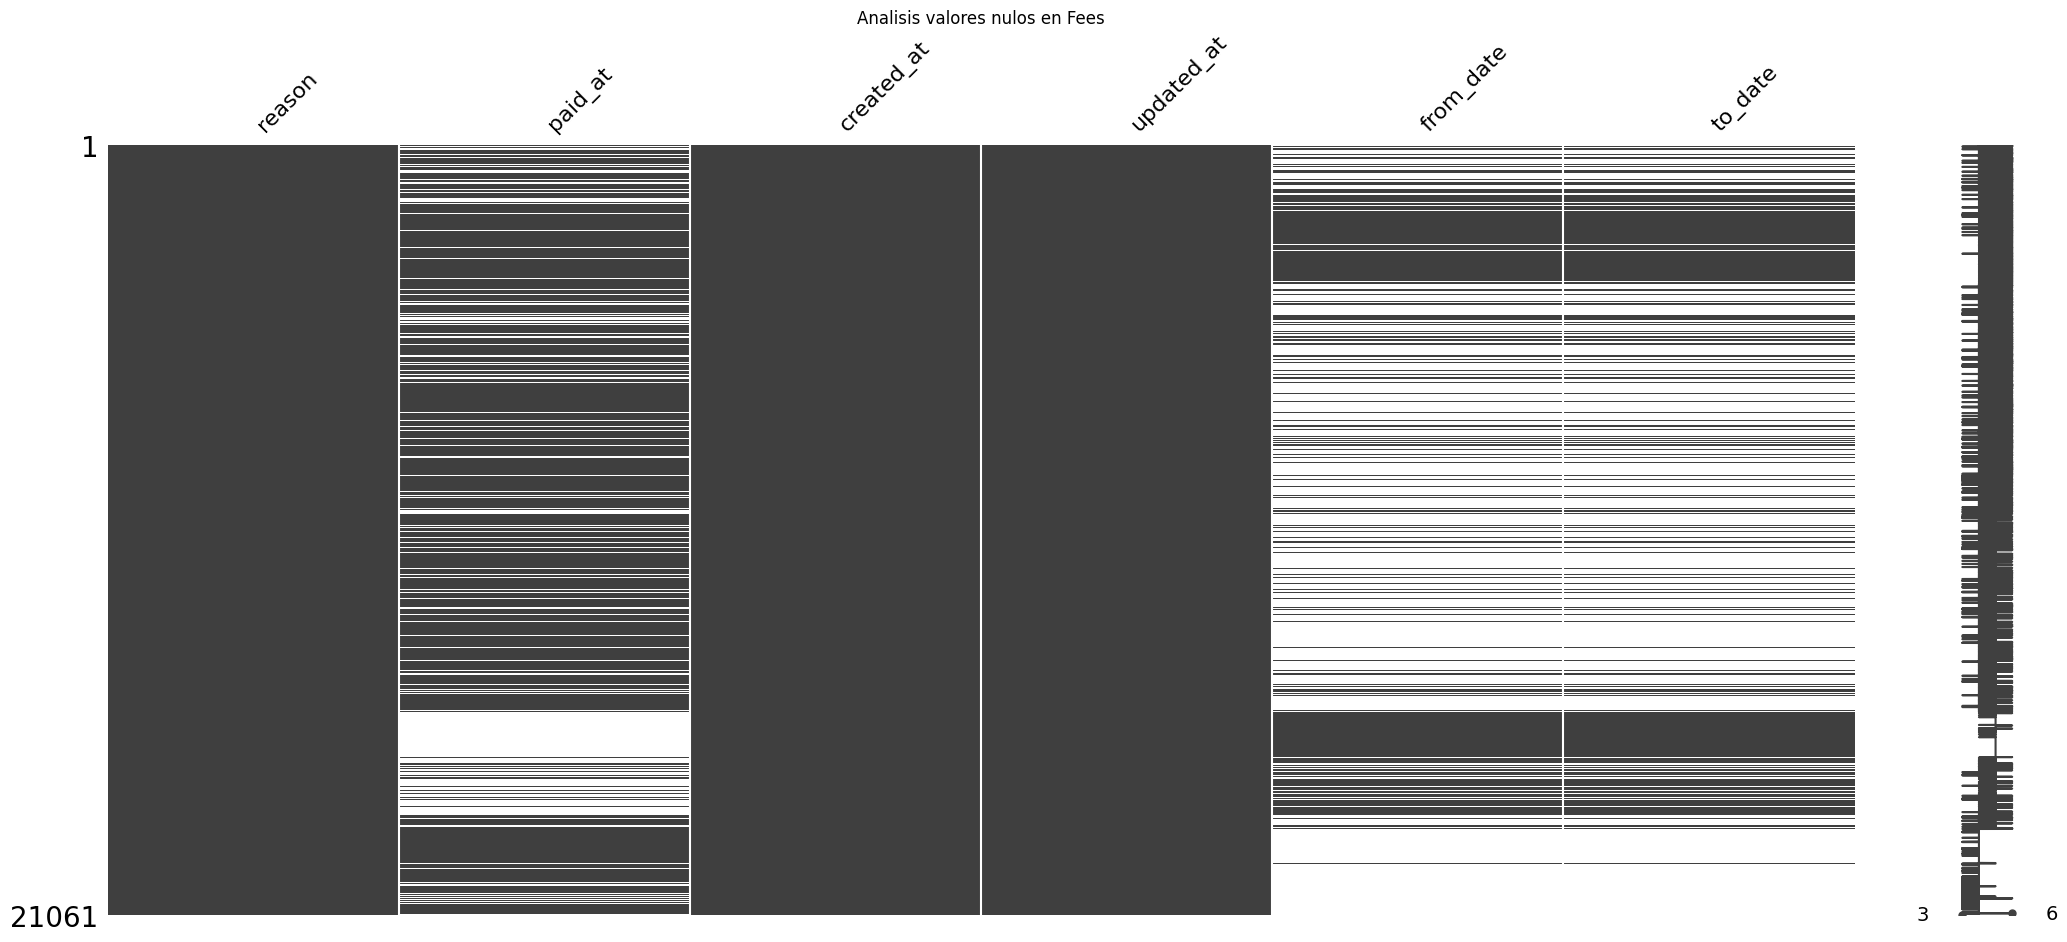

In [23]:
# Visualize missing values
import missingno as msno

reason_grouped = fees[['reason', 'paid_at', 'created_at','updated_at', 'from_date','to_date']]
msno.matrix(reason_grouped)
plt.title("Analisis valores nulos en Fees")
plt.show()